<a href="https://colab.research.google.com/github/hubertrykala93/spam_classification_predict/blob/main/spam_classification_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

np.set_printoptions(suppress=True, edgeitems=30, linewidth=100000,
                    formatter=dict(float=lambda x: f'{x:.8f}'))
np.random.seed(42)

sns.set()

pd.options.display.float_format = '{:,.8f}'.format
pd.set_option('display.width', 320)
pd.set_option('display.max_columns', 100)

Loading Data

In [2]:
path = '/content/SMSCollection.csv'

In [3]:
raw_data = pd.read_csv(filepath_or_buffer=path)
data = raw_data.copy()

Data Analysis

In [4]:
data

,Class,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [5]:
data['Class'] = data['Class'].map(arg=lambda x: 'correct' if x == 'ham' else 'spam')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   5572 non-null   object
 1   sms     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
data.describe(include='object').transpose()

,count,unique,top,freq
Class,5572,2,correct,4825
sms,5572,5169,"Sorry, I'll call later",30


In [8]:
data[data.duplicated()]

,Class,sms
103,correct,As per your request 'Melle Melle (Oru Minnamin...
154,correct,As per your request 'Melle Melle (Oru Minnamin...
207,correct,"As I entered my cabin my PA said, '' Happy B'd..."
223,correct,"Sorry, I'll call later"
326,correct,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...
5535,correct,"I know you are thinkin malaria. But relax, chi..."
5539,correct,Just sleeping..and surfing
5553,correct,Hahaha..use your brain dear


In [9]:
data.drop_duplicates(inplace=True)

In [10]:
data.reset_index(drop=True, inplace=True)

In [11]:
data

,Class,sms
0,correct,"Go until jurong point, crazy.. Available only ..."
1,correct,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,correct,U dun say so early hor... U c already then say...
4,correct,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5164,spam,This is the 2nd time we have tried 2 contact u...
5165,correct,Will ü b going to esplanade fr home?
5166,correct,"Pity, * was in mood for that. So...any other s..."
5167,correct,The guy did some bitching but I acted like i'd...


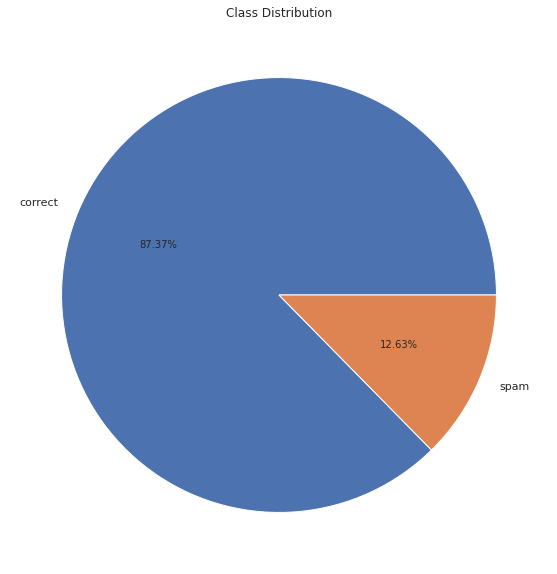

In [12]:
plt.figure(figsize=(10, 10))
plt.pie(x=data['Class'].value_counts(), labels=data['Class'].value_counts().index, autopct='%.2f%%')
plt.title(label='Class Distribution')
plt.show()

Data Preprocessing

In [13]:
X = data['sms']
y = data['Class']

In [14]:
encoder = LabelEncoder()
y = encoder.fit_transform(y=y)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(raw_documents=X_train)
X_test = vectorizer.transform(raw_documents=X_test)

Define Model

In [17]:
classifier = MultinomialNB()

params = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)  
}

grid_search = GridSearchCV(estimator=classifier, param_grid=params,cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X=X_train, y=y_train)
y_pred = grid_search.predict(X=X_test)
y_pred_proba = grid_search.predict_proba(X=X_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [18]:
grid_search.best_params_

{'alpha': 0.01}

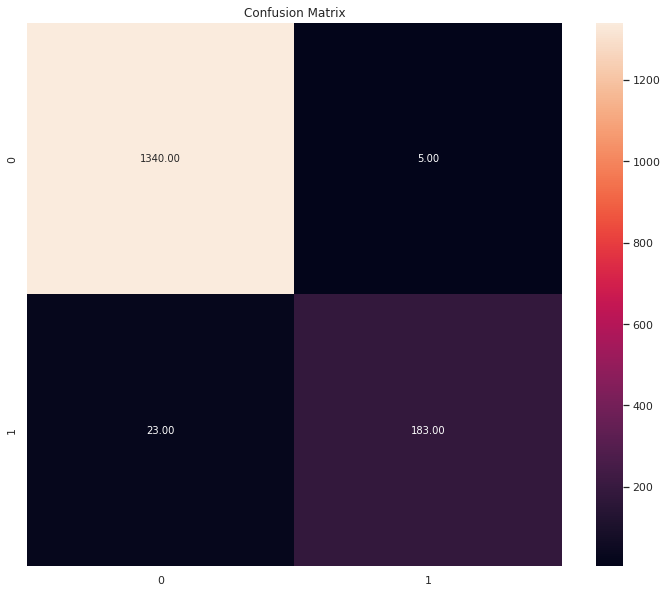

In [19]:
plt.figure(figsize=(12, 10))
sns.heatmap(data=confusion_matrix(y_true=y_test, y_pred=y_pred), annot=True, fmt='.2f')
plt.title(label='Confusion Matrix')
plt.show()

Model Evaluation

In [20]:
fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_pred_proba[:, 1])

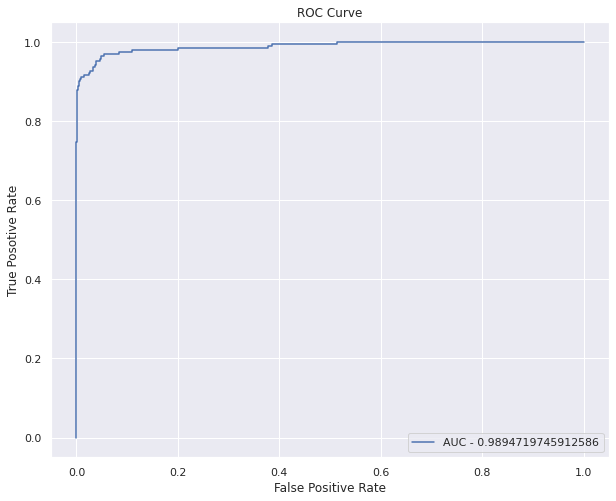

In [21]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'AUC - {roc_auc_score(y_true=y_test, y_score=y_pred_proba[:, 1])}')
plt.title(label='ROC Curve')
plt.xlabel(xlabel='False Positive Rate')
plt.ylabel(ylabel='True Posotive Rate')
plt.legend(loc='lower right')
plt.show()

In [22]:
report = classification_report(y_true=y_test, y_pred=y_pred, target_names=encoder.classes_)
print(report)

              precision    recall  f1-score   support

     correct       0.98      1.00      0.99      1345
        spam       0.97      0.89      0.93       206

    accuracy                           0.98      1551
   macro avg       0.98      0.94      0.96      1551
weighted avg       0.98      0.98      0.98      1551



In [23]:
results = pd.DataFrame(data={
    'y_true': y_test,
    'y_pred': y_pred,
    'flag': y_test == y_pred
})

In [24]:
results

,y_true,y_pred,flag
0,0,0,True
1,1,1,True
2,0,0,True
3,0,0,True
4,1,1,True
...,...,...,...
1546,0,0,True
1547,1,1,True
1548,0,0,True
1549,0,0,True


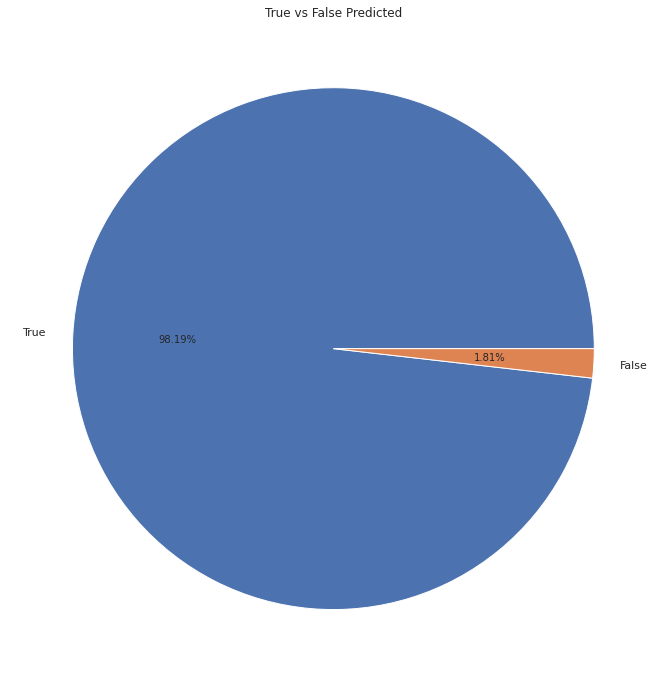

In [25]:
plt.figure(figsize=(12, 12))
plt.pie(x=results['flag'].value_counts().values, labels=results['flag'].value_counts().index, autopct='%.2f%%')
plt.title(label='True vs False Predicted')
plt.show()

In [26]:
results.to_csv(path_or_buf='/content/prediction_results.csv')